In [1]:
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 107.8 MB/s eta 0:00:0000:01


In [1]:
import time
import os
import shutil
from itertools import islice
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import findspark
findspark.init()

from google.cloud import storage

spark = SparkSession.builder \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.maxResultSize", "16g") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.dynamicAllocation.minExecutors", "4") \
    .config("spark.dynamicAllocation.maxExecutors", "100") \
    .getOrCreate()



spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
spark.conf.set("spark.sql.repl.eagerEval.maxCharsPerCell", 200)

print(spark.version)

3.1.3


## Re-read from save

In [12]:
from pyspark.sql.functions import col, count

bucket_write = "gs://msca-bdp-students-bucket/shared_data/xiuan/commits_filtered.parquet"
commits_spDf = spark.read.parquet(bucket_write)

from pyspark.sql.functions import explode

commits_spDf = commits_spDf.withColumn("repo_name_exploded", explode(col("repo_name")))

In [4]:
# Group by repository and count the number of commits
popular_repos = commits_spDf.groupBy("repo_name_exploded").agg(count("*").alias("commit_count"))

# Sort in descending order to find the most popular repositories
popular_repos = popular_repos.orderBy(col("commit_count").desc())

# Show the top 10 popular repositories
popular_repos.show(10, truncate=False)

+--------------------------------+------------+
|repo_name_exploded              |commit_count|
+--------------------------------+------------+
|chromium/chromium               |1197167     |
|shenzhouzd/update               |1188925     |
|scheib/chromium                 |1104843     |
|cminyard/linux-live-app-coredump|1085901     |
|frustreated/linux               |1074488     |
|fabiocannizzo/linux             |1071354     |
|mpe/powerpc                     |1057080     |
|rperier/linux                   |1053624     |
|tprrt/linux-stable              |1044596     |
|HinTak/linux                    |1014842     |
+--------------------------------+------------+
only showing top 10 rows



In [13]:
commits_spDf.printSchema()

root
 |-- commit: string (nullable = true)
 |-- tree: string (nullable = true)
 |-- parent: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- author: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: long (nullable = true)
 |    |    |-- nanos: long (nullable = true)
 |-- committer: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: long (nullable = true)
 |    |    |-- nanos: long (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- trailer: array (nullable = true)
 |    |-- element: struct (contains

In [ ]:
popular_repos.limit(10)

In [9]:
from pyspark.sql.functions import to_date, window

# Convert `committer.time_sec` to timestamp (assuming it's in Unix epoch seconds)
commits_spDf = commits_spDf.withColumn("commit_timestamp", col("committer.time_sec").cast("timestamp"))

# Extract commit date
commits_spDf = commits_spDf.withColumn("commit_date", to_date(col("commit_timestamp")))

# Count commits by repository and time window (e.g., weekly)
growth_trends = commits_spDf.groupBy(window("commit_timestamp", "1 week"), "repo_name") \
    .agg(count("*").alias("weekly_commits"))

# Sort to identify repositories with rapid growth
growth_trends = growth_trends.orderBy(col("weekly_commits").desc())

# Show the top rapidly growing repositories
growth_trends.show(10, truncate=False)


KeyboardInterrupt: 

In [ ]:
from pyspark.sql.functions import when, lower, col, count

# Add a column to categorize repositories based on technologies mentioned in `subject`
commits_spDf = commits_spDf.withColumn(
    "technology",
    when(
        lower(col("subject")).rlike("ai|machine learning|artificial intelligence|ml|data science|ds|llm|large language processing"), 
        "AI"
    )
    .when(lower(col("subject")).contains("blockchain"), "Blockchain")
    .when(
        lower(col("subject")).rlike("cloud|gcp|azure|aws"), 
        "Cloud"
    )
    .when(lower(col("subject")).contains("software"), "Software")
    .when(lower(col("subject")).rlike("web|website"), "Web")
    .otherwise("Other")
)

# Count repositories associated with each technology
tech_distribution = commits_spDf.groupBy("technology").agg(count("*").alias("commit_count"))

# Show technology distribution
tech_distribution.show()



In [ ]:
bucket_write = "gs://msca-bdp-students-bucket/shared_data/xiuan/tech_distribution.parquet"
# Write the DataFrame to GCS as a Parquet file
%time tech_distribution.write \
    .mode("overwrite") \
    .parquet(bucket_write)

print(f"DataFrame successfully written to {bucket_write}")

In [8]:
%time tech_distribution = spark.read.parquet(bucket_write)

rows = tech_distribution.count()
print(f"Total of {rows} in tech_distribution table.")

CPU times: user 4.44 ms, sys: 365 µs, total: 4.81 ms
Wall time: 486 ms
Total of 5 in tech_distribution table.


In [9]:
tech_pd = tech_distribution.toPandas()

tech_pd.head(5)

,technology,commit_count
0,Software,1853378
1,Other,3365879365
2,Cloud,7827697
3,Web,17187024
4,AI,383871627


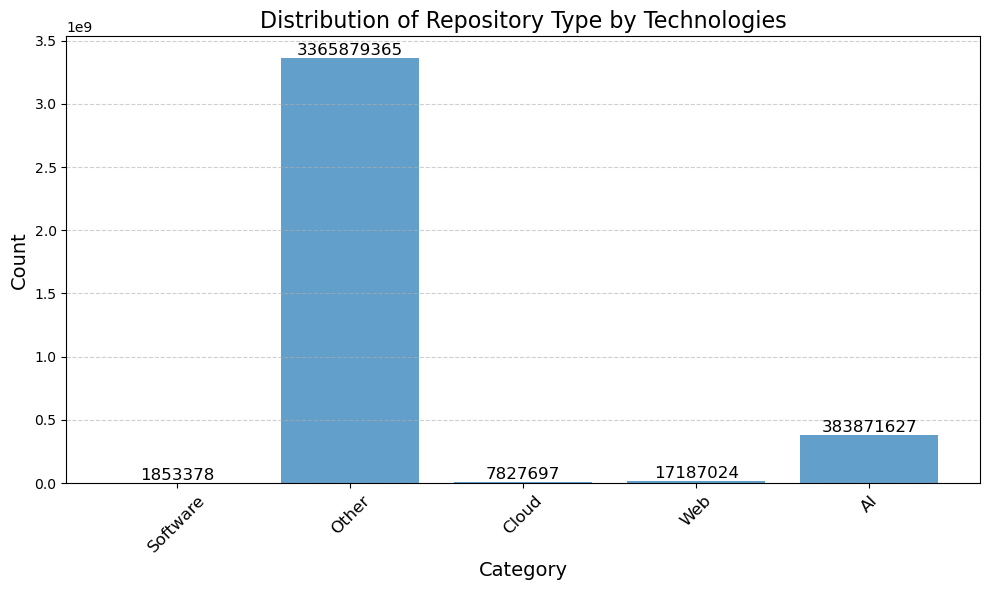

In [10]:
plt.figure(figsize=(10, 6))
bars = plt.bar(tech_pd['technology'], tech_pd['commit_count'], alpha=0.7)

# Add data points on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom', fontsize=12)

# Add labels and title
plt.title('Distribution of Repository Type by Technologies', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

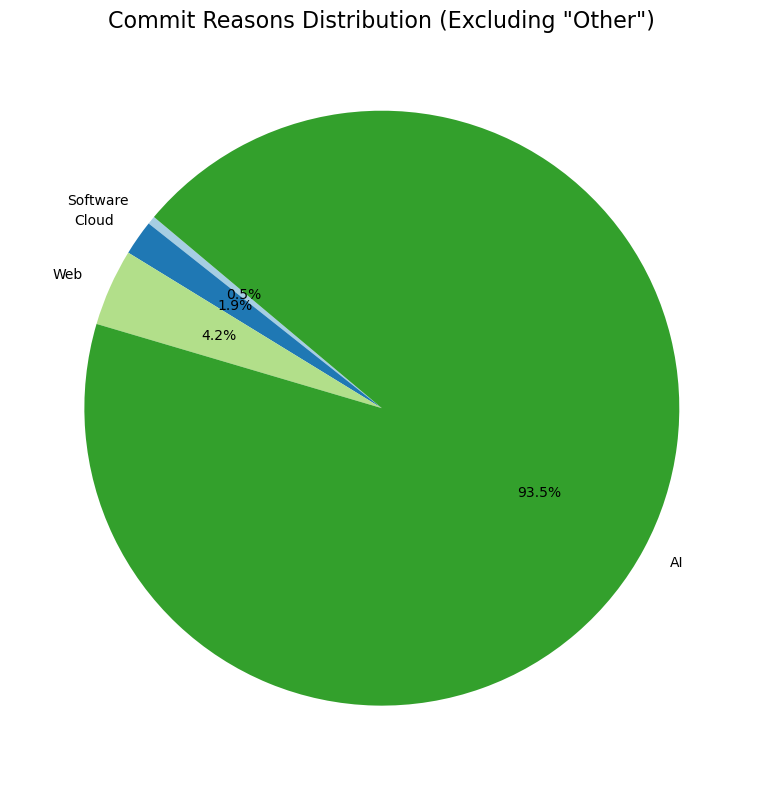

In [14]:
# Filter out the "Other" category
filtered_data = tech_pd[tech_pd['technology'] != "Other"]

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    filtered_data['commit_count'], 
    labels=filtered_data['technology'], 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=plt.cm.Paired.colors
)

# Add title
plt.title('Commit Reasons Distribution (Excluding "Other")', fontsize=16)
plt.tight_layout()
plt.show()

In [18]:
from pyspark.sql.functions import when, lower, col

commits_spDf = commits_spDf.withColumn(
    "AI_tech",
    when(
        lower(col("subject")).rlike("generative|genai|gpt|chatgpt|rag|retrieval augmented generation"), 
        "GenAI"
    ).when(
        lower(col("subject")).rlike("transformer|bert|roberta|distilbert|xlm|t5|llm|large language model"), 
        "Transformer Models"
    ).when(
        lower(col("subject")).rlike("neural network|cnn|convolutional neural network|rnn|recurrent neural network|lstm|gru|deep learning"), 
        "Neural Networks"
    ).when(
        lower(col("subject")).rlike("computer vision|image recognition|object detection|image segmentation|opencv"), 
        "Computer Vision"
    ).when(
        lower(col("subject")).rlike("natural language processing|nlp|text analysis|text mining|ner|named entity recognition|text summarization"), 
        "Natural Language Processing"
    ).when(
        lower(col("subject")).rlike("reinforcement learning|q-learning|policy gradient|actor-critic|dqn|deep q network"), 
        "Reinforcement Learning"
    ).when(
        lower(col("subject")).rlike("machine learning|random forest|decision tree|support vector machine|svm|logistic regression"), 
        "Traditional ML"
    ).when(
        lower(col("subject")).rlike("speech recognition|speech synthesis|text-to-speech|tts|automatic speech recognition|asr"), 
        "Speech Processing"
    ).when(
        lower(col("subject")).rlike("anomaly detection|outlier detection|fraud detection"), 
        "Anomaly Detection"
    ).when(
        lower(col("subject")).rlike("recommendation system|collaborative filtering|content-based filtering"), 
        "Recommendation Systems"
    ).when(
        lower(col("subject")).rlike("clustering|k-means|hierarchical clustering|dbscan"), 
        "Clustering"
    ).when(
        lower(col("subject")).rlike("dimensionality reduction|pca|principal component analysis|tsne|umap"), 
        "Dimensionality Reduction"
    ).when(
        lower(col("subject")).rlike("time series|forecasting|arima|lstm for time series|prophet"), 
        "Time Series Analysis"
    ).when(
        lower(col("subject")).rlike("graph neural network|gnn|graph embedding|node2vec|graph attention network"), 
        "Graph AI"
    ).when(
        lower(col("subject")).rlike("unsupervised learning|self-supervised learning|contrastive learning"), 
        "Unsupervised Learning"
    ).otherwise("Other")
)


In [ ]:
# Count repositories associated with each technology
ai_distribution = commits_spDf.groupBy("AI_tech").agg(count("*").alias("commit_count"))

# Show technology distribution
ai_distribution.limit(5)


24/12/13 00:20:35 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1734033188037_0005_01_000056 on host: hub-msca-bdp-dphub-students-backup-xiuan-sw-d8gb.c.msca-bdp-students.internal. Exit status: 143. Diagnostics: [2024-12-13 00:20:35.772]Container killed on request. Exit code is 143
[2024-12-13 00:20:35.773]Container exited with a non-zero exit code 143. 
[2024-12-13 00:20:35.777]Killed by external signal
.
24/12/13 00:20:35 WARN org.apache.spark.deploy.yarn.YarnAllocator: Cannot find executorId for container: container_1734033188037_0005_01_000067
24/12/13 00:20:35 ERROR org.apache.spark.scheduler.cluster.YarnScheduler: Lost executor 56 on hub-msca-bdp-dphub-students-backup-xiuan-sw-d8gb.c.msca-bdp-students.internal: Container from a bad node: container_1734033188037_0005_01_000056 on host: hub-msca-bdp-dphub-students-backup-xiuan-sw-d8gb.c.msca-bdp-students.internal. Exit status: 143. Diagnostics: [2024-12-13 00:20:35.772]Container killed on req

AI_tech,commit_count
Recommendation Sy...,1417
Clustering,350997
Transformer Models,10199258
Speech Processing,1299176
Unsupervised Lear...,851


In [ ]:
bucket_write = "gs://msca-bdp-students-bucket/shared_data/xiuan/ai_distribution.parquet"
# Write the DataFrame to GCS as a Parquet file
%time ai_distribution.write \
    .mode("overwrite") \
    .parquet(bucket_write)

print(f"DataFrame successfully written to {bucket_write}")

CPU times: user 4.48 s, sys: 906 ms, total: 5.39 s
Wall time: 1h 48min 4s
DataFrame successfully written to gs://msca-bdp-students-bucket/shared_data/xiuan/ai_distribution.parquet


In [2]:
bucket_write = "gs://msca-bdp-students-bucket/shared_data/xiuan/ai_distribution.parquet"
ai_distribution = spark.read.parquet(bucket_write)

In [3]:
ai_tech_pd = ai_distribution.toPandas()

In [4]:
display(ai_tech_pd)

,AI_tech,commit_count
0,Natural Language Processing,86551522
1,Dimensionality Reduction,11463295
2,Reinforcement Learning,8394
3,Recommendation Systems,1417
4,Unsupervised Learning,851
5,Time Series Analysis,73727
6,Transformer Models,10199258
7,Speech Processing,1299176
8,Anomaly Detection,5821
9,Neural Networks,3189221


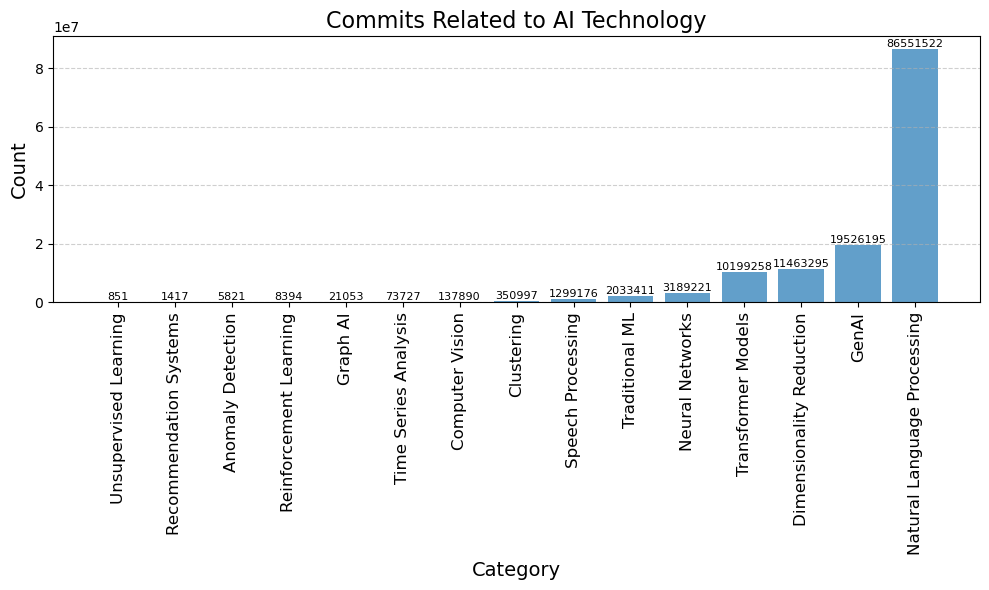

In [14]:
import matplotlib.pyplot as plt
# Drop Other
ai_tech_pd = ai_tech_pd[ai_tech_pd['AI_tech'] != 'Other']
ai_tech_pd = ai_tech_pd.sort_values('commit_count')

plt.figure(figsize=(10, 6))
bars = plt.bar(ai_tech_pd['AI_tech'], ai_tech_pd['commit_count'], alpha=0.7)

# Add data points on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom', fontsize=8)

# Add labels and title
plt.title('Commits Related to AI Technology', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()